In [1]:
%matplotlib inline
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import numpy as np
import math
import typing
import tqdm
import os
import itertools
import copy
import subprocess

from pathlib import Path
from enum import IntEnum
from sklearn.decomposition import FastICA

np.random.seed(42)
tf.random.set_seed(231)
# template name
model_name = "vae{}_weights_100e_550ktr.h5"

TensorFlow 2.x selected.


# Build a model according to specification (Tbl. 1 Higgins et al.)
* **Input**  4096 (flattened 64x64x1).
* **Encoder**  FC 1200, 1200. ReLU activation.
* **Latents**  10
* **Decoder**  FC 1200, 1200, 1200, 4096. Tanh activation. Bernoulli.
* **Optimiser** Adagrad 1e-2

In [0]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self._latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer((64, 64, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1200, activation='relu'),
            tf.keras.layers.Dense(1200, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(latent_dim),
            tf.keras.layers.Dense(1200, activation='tanh'),
            tf.keras.layers.Dense(1200, activation='tanh'),
            tf.keras.layers.Dense(1200, activation='tanh'),
            tf.keras.layers.Dense(4096),
            tf.keras.layers.Reshape((64, 64, 1))
        ])

    def call(self, x): raise NotImplementedError

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = tf.split(h, num_or_size_splits=2, axis=1)
        return self.reparameterise(mean, logvar), mean, logvar
    
    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparameterise(mean, logvar):
        # log sig^2 = 2 log sig => exp(1/2 log sig^2) = exp(log sig) = sig
        eps = tf.random.normal(mean.shape, mean=0.0, stddev=1.0)
        return mean + tf.exp(logvar * 0.5) * eps

BETA = 4
EPOCHS = 100
LATENT_DIM = 10
BATCH_SIZE = 32
TR_SIZE = 550_000

In [0]:
class PCA:
    def __init__(self, latent_dim: int, ds: 'DSprites', subset: int=100_000):
        x = ds.subset(subset)
        self._width = x.shape[1]
        self._height = x.shape[2]
        self.mean = np.mean(x, axis=0)
        self._latent_dim = latent_dim
        self._D = self._width * self._height
        x = (x - self.mean).reshape(-1, self._D)
        self._e, V = tf.linalg.eigh(tf.matmul(x.T, x))
        assert V.shape == (self._D, self._D)
        # non-decreasing => take the last latent_dim cols!
        self.V_k = V[:, -self._latent_dim:]
    
    def encode(self, x):
        x = (x - self.mean).reshape(-1, self._D)
        z = tf.matmul(x, self.V_k)
        assert z.shape == (x.shape[0], self._latent_dim)
        # our VAE encoders return z, mean, logvar
        # and our data generator takes the mean (see generate_benchmarking_dataset)
        # so we have to return z in the middle of a 3-tuple
        return z, z, None
    
    def decode(self, z):
        return tf.matmul(z, self.V_k, transpose_b=True).numpy().reshape(-1, self._width, self._height, 1) # + self.mean

    @property
    def explained_variance_ratio(self):
        e = self._e.numpy()[::-1]       
        return e[: self._latent_dim]/sum(e)

class ICA:
    def __init__(self, latent_dim: int, ds: 'DSprites', subset: int=100_000):
        x = ds.subset(subset)
        self._width = x.shape[1]
        self._height = x.shape[2]
        self._D = self._width * self._height
        self._model = FastICA(n_components=latent_dim)
        self._model.fit(x.reshape(-1, self._D))

    def encode(self, x):
        z = self._model.transform(x.reshape(-1, self._D))
        return z, z, None

    def decode(self, z):
        return self._model.inverse_transform(z).reshape(-1, self._width, self._height, 1)

In [0]:
class DSprites:
    class Latents(IntEnum):
        COLOUR, SHAPE, SCALE, ORIENTATION, XPOS, YPOS = range(6)
        
    """
    A significant portion of this class is taken as-is from the manual
    https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb
    """
    def __init__(self, path=".", download=False):
        self._filename = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
        path = Path(path).absolute()
        assert path.exists()
        data = path / self._filename
        if not data.exists():
            if download:
                subprocess.run(["wget", "-O", str(data),
                                "https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"])
            else:
                raise ValueException("Can't find dataset, use download=True to download.")
        data = np.load(str(data), encoding='bytes', allow_pickle=True)

        # ====

        imgs = data['imgs']
        metadata_raw = data['metadata'][()]
        self._metadata = dict()
        for k, v in metadata_raw.items():
            self._metadata[k.decode()] = v

        # NOTE: can't cast now because our notebook runs out of RAM. cast in map instead
        # imgs = imgs.reshape(-1, 64, 64, 1).astype(np.float32)
        self._imgs = imgs.reshape(-1, 64, 64, 1)

        # for example: array([ 0,  0,  2, 37, 15, 22])
        # i.e. the relative (normalised) change in latent factors
        self._latents_classes = data['latents_classes']

        # for example: array([1., 1., 0.7 , 5.96097068, 0.48387097, 0.70967742])
        # i.e. the actual latent values used to generate the image
        self._latents_values = data['latents_values']

        # specification: the number of varying "degrees" of change in each
        # dimension corresponding to an independent generative factor
        # array([ 1,        3,      6,           40,  32,  32])
        #       colour, shape,  scale,  orientation,   X,   Y
        self._latents_sizes = self._metadata['latents_sizes']

        # for easy conversion from latent vector to indices later (see latent_to_idx)
        # essentially: array([737280, 245760,  40960,   1024,     32,      1])
        self._latents_bases = np.r_[self._latents_sizes[::-1].cumprod()[::-1][1:], 1]
    
    def latent_size(self, latent: 'DSprites.Latents') -> int:
        """
        :param latent: of type DSprites.Latents (an enum class)
        :return: the maximum integer allowed for the specified `latent`
        """
        return self._latents_sizes[latent.value]
    
    def to_idx(self, latents: np.array) -> int:
        """
        convert latent vector into index that can then be used to index
        the actual image in self._imgs
        """
        return np.dot(latents, self._latents_bases).astype(int)
    
    def sample_latent(self, n: int=1, fixed: 'DSprites.Latents'=None) -> np.array:
        """
        randomly samples `n` latent vectors

        :param n: number samples
        :param fixed: if not `None`, then in all samples, this latent is kept
                     fixed based on a random draw. The rest of the latents are
                     random.
        :return: an `np.array` of shape nx6
        """
        samples = np.zeros((n, self._latents_sizes.shape[0]))
        for i, lat_size in enumerate(self._latents_sizes):
            samples[:, i] = np.random.randint(lat_size, size=n)
        if fixed:
            samples[:, fixed] = np.random.randint(0, ds.latent_size(fixed))
        return samples
    
    @property
    def imgs(self) -> np.array:
        return self._imgs

    def subset(self, size=50_000) -> np.array:
        """
        returns a subset of the images. (Workaround for memory constraints)
        :param size: number of samples to return
        """
        return self._imgs[np.random.choice(self._imgs.shape[0], size=size, replace=False)]

def make_grid(tensor: np.array, nrow: int=8, padding: int=2, pad_value: int=0) -> np.array:
    """
    adapted from: https://pytorch.org/docs/stable/_modules/torchvision/utils.html#make_grid
    :param tensor: nxwxhxc np.array
    :param nrow: number of images displayed in each row
    :param padding: padding between images
    :param pad_value: value used to pad
    :return: np.array of dimension 3 (WxHxC) with all images arranged in a grid.

    """
    if tensor.shape[0] == 1:
        return tensor.squeeze()

    # make the mini-batch of images into a grid
    nmaps = tensor.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.shape[1] + padding), int(tensor.shape[2] + padding)
    num_channels = tensor.shape[3]
    grid = np.full((height * ymaps + padding, width * xmaps + padding, num_channels), pad_value, dtype=tensor.dtype)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps: break
            ystart = y * height + padding
            xstart = x * width + padding
            grid[ystart:(ystart + height - padding), ...][:, xstart:(xstart + width - padding), :] = tensor[k]
            k = k + 1
    return grid.squeeze()

def imshow(img: np.array, title: str='', ax: plt.Axes=None):
    if not ax:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_xticks(())
    ax.set_yticks(())
    if title:
        ax.set_title(title)

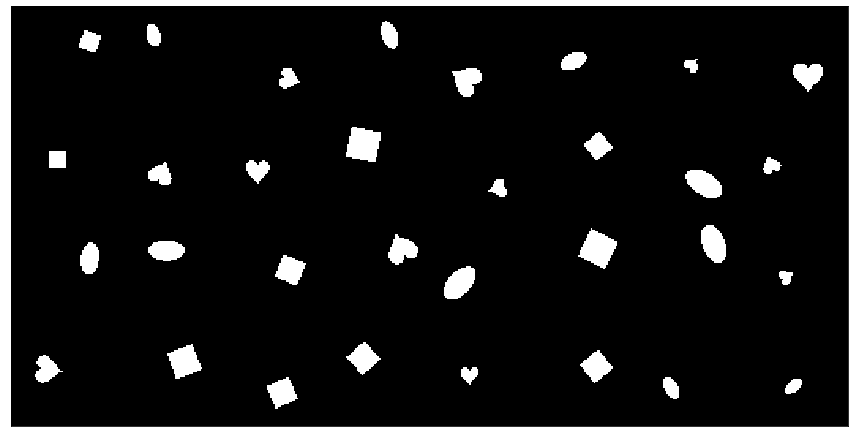

In [5]:
ds = DSprites(download=True)
test_batch = ds.subset(size=32)
imshow(make_grid(test_batch))

In [0]:
# pca = PCA(LATENT_DIM, ds, subset=75_000)
# print(pca.explained_variance_ratio)
# print(sum(pca.explained_variance_ratio))

# # simple sanity check
# z, *_ = pca.encode(test_batch)
# fig = plt.figure(figsize=(15, 15))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# imshow(make_grid(test_batch), title='Original', ax=ax1)
# imshow(make_grid(pca.decode(z)), title='Reconstructed', ax=ax2)
# fig.subplots_adjust(wspace=0.01)
# plt.show()

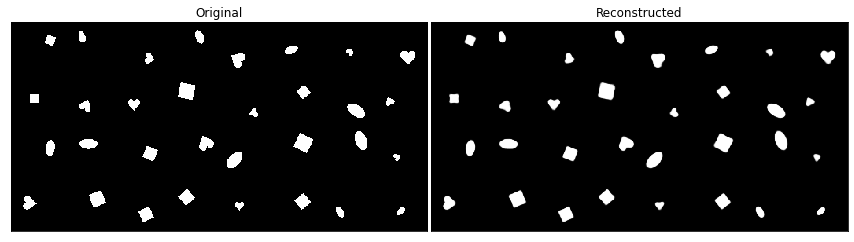

In [7]:
vae05 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae05.load_weights(model_name.format("0.5"))

# simple sanity check
z, *_ = vae05.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae05.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

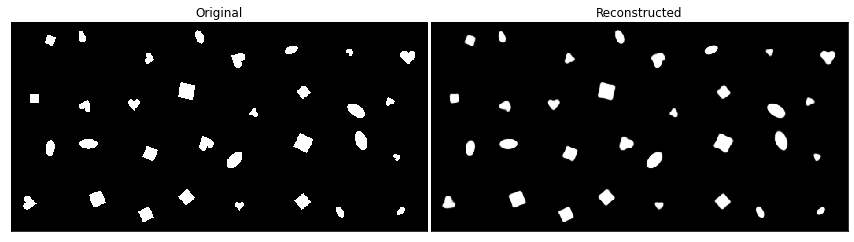

In [8]:
vae1 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae1.load_weights(model_name.format(1))

# simple sanity check
z, *_ = vae1.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae1.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

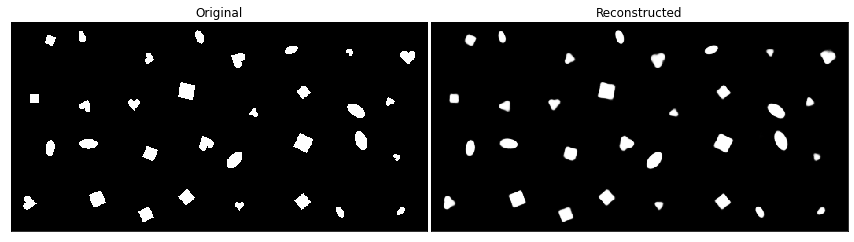

In [9]:
vae2 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae2.load_weights(model_name.format(2))

# simple sanity check
z, *_ = vae2.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae2.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

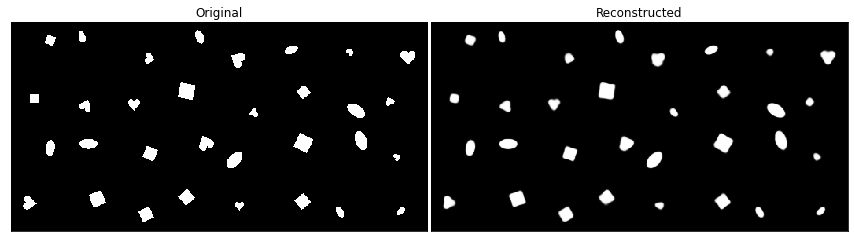

In [10]:
vae3 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae3.load_weights(model_name.format(3))

# simple sanity check
z, *_ = vae3.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae3.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

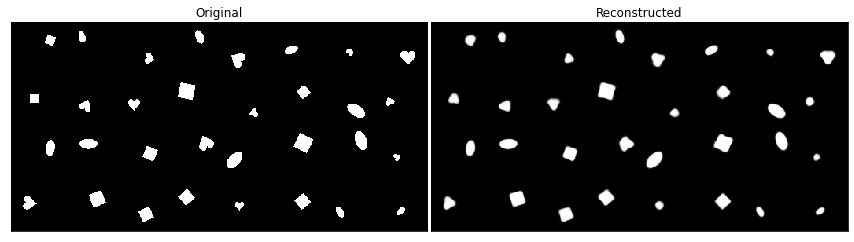

In [11]:
vae4 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae4.load_weights(model_name.format(4))

z, *_ = vae4.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae4.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

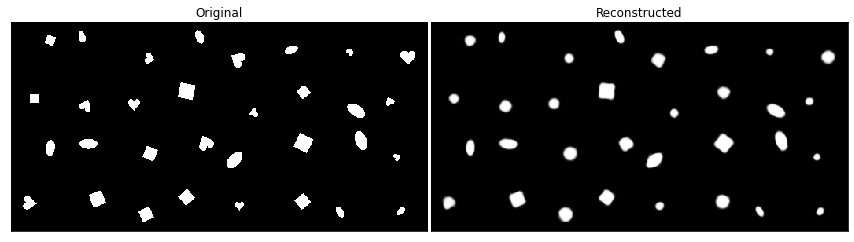

In [12]:
vae5 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae5.load_weights(model_name.format(5))

# simple sanity check
z, *_ = vae5.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae5.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

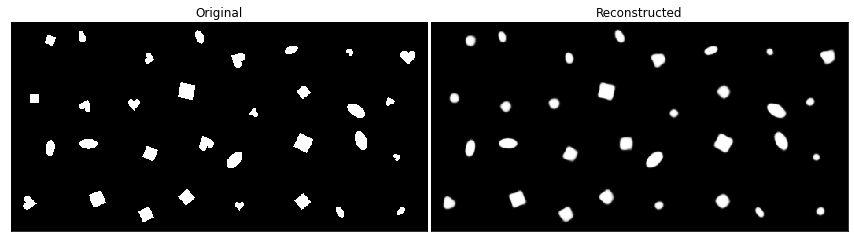

In [13]:
vae6 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae6.load_weights(model_name.format(6))

# simple sanity check
z, *_ = vae6.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae6.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

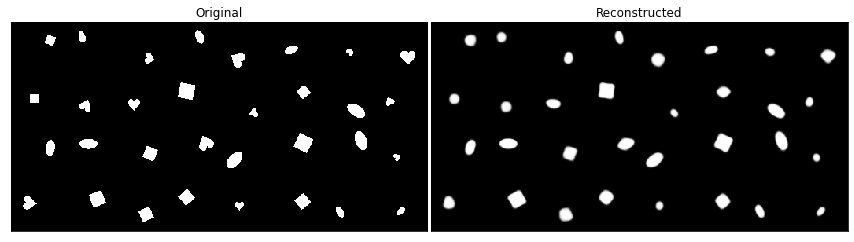

In [14]:
vae7 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae7.load_weights(model_name.format(7))

# simple sanity check
z, *_ = vae7.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae7.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

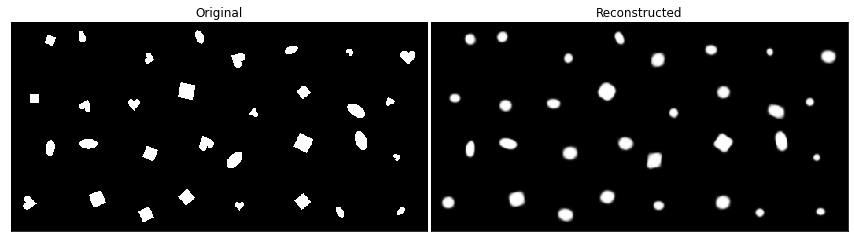

In [15]:
vae8 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae8.load_weights(model_name.format(8))

# simple sanity check
z, *_ = vae8.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae8.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

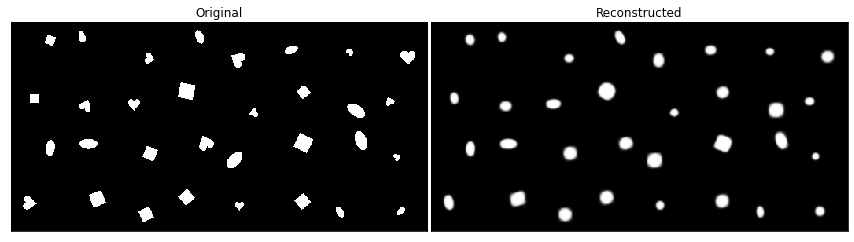

In [16]:
vae9 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae9.load_weights(model_name.format(9))

# simple sanity check
z, *_ = vae9.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae9.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

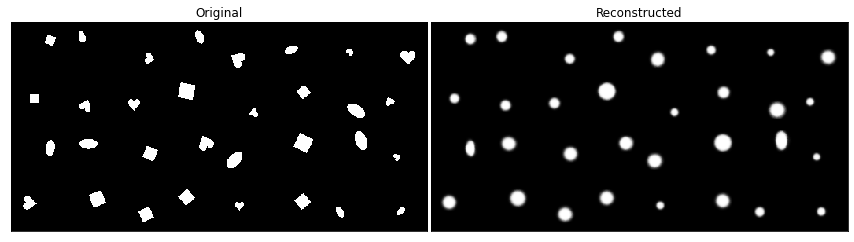

In [17]:
vae10 = VAE(LATENT_DIM)
# load pretrained model with 100 epochs (from 550k randomly sampled points)
vae10.load_weights(model_name.format(10))

# simple sanity check
z, *_ = vae10.encode(test_batch)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
imshow(make_grid(test_batch), title='Original', ax=ax1)
imshow(make_grid(tf.nn.sigmoid(vae10.decode(z)).numpy()), title='Reconstructed', ax=ax2)
fig.subplots_adjust(wspace=0.01)
plt.show()

In [0]:
# vae_untrained = VAE(LATENT_DIM)

# z, *_ = vae_untrained.encode(test_batch)
# fig = plt.figure(figsize=(15, 15))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# imshow(make_grid(test_batch), title='Original', ax=ax1)
# imshow(make_grid(tf.nn.sigmoid(vae_untrained.decode(z)).numpy()), title='Reconstructed', ax=ax2)
# fig.subplots_adjust(wspace=0.01)
# plt.show()

# Generating $z^b_{diff}$

for batch $b$ = 1 ... B:
   1. sample $y_b$ from Unif(SCALE, XPOS, YPOS, ORIENTATION)
   2. repeat L times to get $z^{l=1}_{diff}$, $\dots$, $z^{l=L}_{diff}$:
   
        (a) sample latents vectors $v_{1, l}$ and $v_{2, l}$ where the value in the dimension corresponding to $y_b$ is kept fixed.

        (b) generate images $x_{1, l}$ and $x_{2, l}$ from $Sim(v_{1, l})$ and $Sim(v_{2, l})$

        (c) calculate $z_{1, l} = \mu(x_{1, l})$ where $\mu(.)$ is the (neural network) encoder portion that is responsible for outputting the mean of the posterior $q_\phi(\mathbf z| \mathbf x) = \mathcal N\left(\mathbf z; \mu(\mathbf x), \Sigma(\mathbf x)\right)$; likewise $z_{2,l} = \mu(x_{2, l})$ 

        (d) finally, calculate $z^l_{diff} = |z_{1, 1} - z_{2,l}|$

3. we obtain $z^b_{diff} = \frac{1}{L}\sum_l^L z^l_{diff}$

The `generate_benchmarking_dataset` function then returns $z^{b=1}_{diff}, \dots, z^{b=B}_{diff}$  and their corresponding fixed latents $y_b$.

> Note that **colour** and **shape** are not evaluated. **Colour** is understandable as all
images are white, however, **shape** is conspicously left out, perhaps because the paper (and in our reproduced result) shows that none of the learnt latents encode **shape**.

In [0]:
def generate_benchmarking_dataset(model: VAE,
                                  ds: DSprites, l: int,
                                  batches: int,
                                  with_shapes: bool=False) -> typing.Tuple[np.array, np.array]:
    """
    :param model: must have an `encode` function that takes a tensor of shape
                  N x W x H x C and returns a tuple (z, mean, logvar)
                  where all three elements are of shape N x LATENT_DIM
    :param ds: DSprites dataset                 
    :param l: number of samples to draw for a given fixed latent. Corresponds
              to the same L described in the paper.
    :param batches: number of batches. Corresponds to the same B
                    described in the paper.
    :param with_shapes: should shapes be included as a fixed latent or ignored?
                        By default it is ignored as the paper did too.
    :return: a tuple of x and y where x is an array of shape  b x LATENT_DIM
             and y is an array of length b. That is, x[b] = z^b_diff.
    """                                
    x = []
    y = []
    # here, each batch is allowed to fix a different latent factor
    for b in tqdm.trange(batches):
        # low=2 because 0 is COLOUR which is always fixed and 1 is SHAPE
        # but the paper doesn't evaluate SHAPEs
        least_latent_idx = 1 if with_shapes else 2
        y_fixed = DSprites.Latents(
            np.random.randint(low=least_latent_idx, high=6, size=1)
        )
        assert y_fixed != DSprites.Latents.COLOUR and (with_shapes or y_fixed != DSprites.Latents.SHAPE)

        # 2*l x LATENT_DIM: 2*l because for each l we take the difference of 2 Zs
        _, mean, _ = model.encode(
            ds.imgs[ds.to_idx(ds.sample_latent(n=(2 * l), fixed=y_fixed))]
        )

        # z_{1,l} = mean(x_{1,l}); z_{2,l} = mean(x_{2,l})
        # z^b_diff = average_l(z^l_diff) where z^l_diff = |z_{1,l} - z_{2,l}|

        zldiff = np.array([tf.abs(mean[i] - mean[i + 1]).numpy() for i in range(0, 2 * l, 2)])
        assert zldiff.shape == (l, mean.shape[1])
        zbdiff = np.mean(zldiff, axis=0)
        assert zbdiff.shape == (mean.shape[1], )
        x.append(zbdiff)
        assert y_fixed.value >= least_latent_idx
        # the integers are expected to start from 0 but we start from low=least_latent_idx
        # hence, we have to shift it.
        y.append(y_fixed.value - least_latent_idx)
    return np.array(x), np.array(y)

# Quantitative measure: Linear classifer

From Higgins et al. (2017):
> We used a fully connected linear classifier to predict $p(y|\mathbf z^b_{diff})$, where y is one of four generative factors (position X, position Y, scale
and rotation). We used softmax output nonlinearity and a negative log likelihood loss function. The classifier was trained using the Adagrad (Duchi et al., 2011) optimisation algorithm with learning rate of 1e-2 until convergence.

The code below is an exact translation of the excerpt above.

In [20]:
def get_linear_classifier(num_classes=4) -> tf.keras.Model:
    """
    :param num_classes: number of output classes. By default, there are
                        four: XPOS, YPOS, SCALE, ORIENTATION/ROTATION.
    :return: keras model. A linear classifier that's essentially a multiclass
             logistic regression.
    """
    model = tf.keras.Sequential([
       tf.keras.layers.InputLayer((LATENT_DIM,)),
       tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=1e-2),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    return model
get_linear_classifier().summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 4)                 44        
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________


## Evaluating the models

In this experiement, we'll reproduce the results for $\beta$-vae, regular vae, and PCA. From the paper, it states that
"[t]en replicas of each model with the same hyperparameters were trained using different random seeds to obtain disentangled representations. Each of the ten trained model replicas was evaluated three times using the disentanglement metric score algorithm, each time using a different random seed to initialise the linear classifier. We then discarded the bottom 50% of the thirty resulting scores and reported the remaining results. This was done to control for the outlier results from the few experiments that diverged during training.".

In summary, there are ten independent copies of each model each trained separately (different seeds used for weight initializations) but identically. Next, each of the ten models are evaulated thrice using the linear classifier and the bottom 50% of the thirty resulting scores are discarded.

Here, instead of having ten independent copies of the models, we'll have one each but evaluated three times using the linear classifier. Therefore, instead of thirty scores per model, we will only have three. *Arguably, as long as our results do not diverge, a single model should suffice.*

Later, we will also evaluate the models **with** shape included as the fixed generative factor to see how it affects the metric, despite none of the $z_i$s showing that it identified shape as an independent latent.

In [0]:
# how many times to repeat the experiment. Each repetition creates a
# new linear classifier with different initial values
REPEAT = 3
# in each batch, we take the average of L zdiffs
L = 64
# take B batches, i.e. creating a dataset of size (B, LATENT_DIM)
B = 10_000
# section 4.2: The table in Fig. 6 (left) reports the classification accuracy of the disentanglement metric for 5,000 test samples
E = 5_000

In [0]:
def run_experiment(model: VAE, ds: DSprites, l: int, batches: int, test_batch: int,
                   reps: int, with_shapes: bool=False, verbose: int=1) -> np.array:
    """
    :param model: must have an `encode` function that takes a tensor of shape
                  N x W x H x C and returns a tuple (z, mean, logvar)
                  where all three elements are of shape N x LATENT_DIM
    :param ds: DSprites object used to generate dataset                 
    :param l: number of samples to draw for a given fixed latent. Corresponds
              to the same L described in the paper.
    :param batches: number of batches. Corresponds to the same B
                    described in the paper.
    :param test_batch: number of test batch. The paper used 5,000 test points
                       to evulate the accuracy of the linear classifier.                   
    :param reps: number of times to repeat this experiment.
    :param with_shapes: should shapes be included as a latent factor that should
                        be measured?
    :param verbose: verbosity level of model.fit(..., verbose) where model
                    is of type `tf.keras.Model`.
    :return: an np.array of accuracies. This array is of length `reps`, where
             each element corresponds to the maximum accuracy
             obtained during training for that particular iteration.
    """
    # create data (z^b_diff)s
    x_train, y_train = generate_benchmarking_dataset(model, ds,
                                                     l=l, batches=(batches + test_batch),
                                                     with_shapes=with_shapes)
    x_train = x_train[: batches]
    y_train = y_train[: batches]
    x_test = x_train[-test_batch:]
    y_test = y_train[-test_batch:]

    assert x_train.shape == (B, LATENT_DIM) and y_train.shape == (B, )
    assert x_test.shape == (E, LATENT_DIM) and y_test.shape == (E, )
    assert ((y_train < (5 if with_shapes else 4)) & (y_train >= 0)).all()
    assert ((y_test < (5 if with_shapes else 4)) & (y_test >= 0)).all()
    
    # show target class distribution
    counts = dict(zip(*np.unique(y_train, return_counts=True)))
    plt.bar([DSprites.Latents(k + (1 if with_shapes else 2)).name for k in counts.keys()], counts.values())
    plt.title(f"Distribution of fixed latents in {B:,} samples.")
    print(counts)

    accuracies = []
    for r in range(1, reps + 1):
        print(f"\n\n==========\nExperiment {r}")
        linear_classifier = get_linear_classifier(num_classes=(5 if with_shapes else 4))
        # use this callback as a monitor - use an absurd number of epochs and stop
        # only when the accuracy doesn't improve
        until_convergence = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             min_delta=1e-5,
                                                             patience=10)          
        history = linear_classifier.fit(x_train, y_train,
                                      batch_size=32, epochs=500,
                                      callbacks=[until_convergence],
                                      verbose=verbose)
        accuracies.append(linear_classifier.evaluate(x_test, y_test)[-1])
        
    return np.array(accuracies)

In [23]:
accs = []
for vae in [vae05, vae1, vae2, vae3, vae4, vae5, vae6, vae7, vae8, vae9, vae10]:
    accs.append(run_experiment(vae, ds, l=L, batches=B, test_batch=E, reps=REPEAT, with_shapes=False))

# 11x3 matrix
accs = np.array(accs)
print(np.mean(accs, axis=1))
print(np.std(accs, axis=1))

100%|██████████| 15000/15000 [07:58<00:00, 31.37it/s]


{0: 2550, 1: 2416, 2: 2522, 3: 2512}


Experiment 1
Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 99us/sample - loss: 1.3512 - accuracy: 0.2992
Epoch 2/500
10000/10000 [==============================] - 1s 64us/sample - loss: 1.3067 - accuracy: 0.4385
Epoch 3/500
10000/10000 [==============================] - 1s 68us/sample - loss: 1.2947 - accuracy: 0.4959
Epoch 4/500
10000/10000 [==============================] - 1s 63us/sample - loss: 1.2849 - accuracy: 0.5138
Epoch 5/500
10000/10000 [==============================] - 1s 65us/sample - loss: 1.2767 - accuracy: 0.5247
Epoch 6/500
10000/10000 [==============================] - 1s 66us/sample - loss: 1.2693 - accuracy: 0.5417
Epoch 7/500
10000/10000 [==============================] - 1s 66us/sample - loss: 1.2628 - accuracy: 0.5498
Epoch 8/500
10000/10000 [==============================] - 1s 64us/sample - loss: 1.2568 - accuracy: 0.5519
Epoch 9/500
10000/10000 [==============================] - 1s

100%|██████████| 15000/15000 [07:52<00:00, 31.76it/s]


{0: 2525, 1: 2488, 2: 2507, 3: 2480}


Experiment 1
Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 80us/sample - loss: 1.4446 - accuracy: 0.2347
Epoch 2/500
10000/10000 [==============================] - 1s 64us/sample - loss: 1.3515 - accuracy: 0.2999
Epoch 3/500
10000/10000 [==============================] - 1s 67us/sample - loss: 1.3324 - accuracy: 0.3806
Epoch 4/500
10000/10000 [==============================] - 1s 66us/sample - loss: 1.3171 - accuracy: 0.4557
Epoch 5/500
10000/10000 [==============================] - 1s 69us/sample - loss: 1.3042 - accuracy: 0.4786
Epoch 6/500
10000/10000 [==============================] - 1s 67us/sample - loss: 1.2928 - accuracy: 0.5225
Epoch 7/500
10000/10000 [==============================] - 1s 64us/sample - loss: 1.2825 - accuracy: 0.5508
Epoch 8/500
10000/10000 [==============================] - 1s 67us/sample - loss: 1.2730 - accuracy: 0.5742
Epoch 9/500
10000/10000 [==============================] - 1s

100%|██████████| 15000/15000 [07:58<00:00, 31.33it/s]


{0: 2512, 1: 2478, 2: 2484, 3: 2526}


Experiment 1
Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 88us/sample - loss: 1.4627 - accuracy: 0.2900
Epoch 2/500
10000/10000 [==============================] - 1s 70us/sample - loss: 1.3917 - accuracy: 0.3504
Epoch 3/500
10000/10000 [==============================] - 1s 65us/sample - loss: 1.3800 - accuracy: 0.3630
Epoch 4/500
10000/10000 [==============================] - 1s 71us/sample - loss: 1.3706 - accuracy: 0.3810
Epoch 5/500
10000/10000 [==============================] - 1s 67us/sample - loss: 1.3624 - accuracy: 0.4021
Epoch 6/500
10000/10000 [==============================] - 1s 71us/sample - loss: 1.3552 - accuracy: 0.4105
Epoch 7/500
10000/10000 [==============================] - 1s 73us/sample - loss: 1.3486 - accuracy: 0.4246
Epoch 8/500
10000/10000 [==============================] - 1s 69us/sample - loss: 1.3425 - accuracy: 0.4473
Epoch 9/500
10000/10000 [==============================] - 1s

100%|██████████| 15000/15000 [07:55<00:00, 31.52it/s]


{0: 2549, 1: 2427, 2: 2497, 3: 2527}


Experiment 1
Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 106us/sample - loss: 1.3305 - accuracy: 0.3966
Epoch 2/500
10000/10000 [==============================] - 1s 69us/sample - loss: 1.2247 - accuracy: 0.7201
Epoch 3/500
10000/10000 [==============================] - 1s 69us/sample - loss: 1.1626 - accuracy: 0.8470
Epoch 4/500
10000/10000 [==============================] - 1s 66us/sample - loss: 1.1151 - accuracy: 0.8852
Epoch 5/500
10000/10000 [==============================] - 1s 69us/sample - loss: 1.0759 - accuracy: 0.9273
Epoch 6/500
10000/10000 [==============================] - 1s 68us/sample - loss: 1.0425 - accuracy: 0.9438
Epoch 7/500
10000/10000 [==============================] - 1s 72us/sample - loss: 1.0133 - accuracy: 0.9306
Epoch 8/500
10000/10000 [==============================] - 1s 69us/sample - loss: 0.9873 - accuracy: 0.9486
Epoch 9/500
10000/10000 [==============================] - 1

100%|██████████| 15000/15000 [07:56<00:00, 31.51it/s]


{0: 2549, 1: 2495, 2: 2491, 3: 2465}


Experiment 1
Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 81us/sample - loss: 1.5499 - accuracy: 0.2689
Epoch 2/500
10000/10000 [==============================] - 1s 68us/sample - loss: 1.3749 - accuracy: 0.3279
Epoch 3/500
10000/10000 [==============================] - 1s 70us/sample - loss: 1.3014 - accuracy: 0.3096
Epoch 4/500
10000/10000 [==============================] - 1s 64us/sample - loss: 1.2461 - accuracy: 0.3530
Epoch 5/500
10000/10000 [==============================] - 1s 65us/sample - loss: 1.2007 - accuracy: 0.4783
Epoch 6/500
10000/10000 [==============================] - 1s 68us/sample - loss: 1.1619 - accuracy: 0.6011
Epoch 7/500
10000/10000 [==============================] - 1s 70us/sample - loss: 1.1279 - accuracy: 0.6531
Epoch 8/500
10000/10000 [==============================] - 1s 73us/sample - loss: 1.0977 - accuracy: 0.6895
Epoch 9/500
10000/10000 [==============================] - 1s

100%|██████████| 15000/15000 [08:23<00:00, 29.77it/s]


{0: 2513, 1: 2480, 2: 2515, 3: 2492}


Experiment 1
Train on 10000 samples
Epoch 1/500
10000/10000 [==============================] - 1s 83us/sample - loss: 1.4367 - accuracy: 0.2574
Epoch 2/500
10000/10000 [==============================] - 1s 67us/sample - loss: 1.2663 - accuracy: 0.3910
Epoch 3/500
10000/10000 [==============================] - 1s 71us/sample - loss: 1.2003 - accuracy: 0.5596
Epoch 4/500
10000/10000 [==============================] - 1s 73us/sample - loss: 1.1544 - accuracy: 0.6376
Epoch 5/500
10000/10000 [==============================] - 1s 70us/sample - loss: 1.1181 - accuracy: 0.6552
Epoch 6/500
10000/10000 [==============================] - 1s 72us/sample - loss: 1.0878 - accuracy: 0.6808
Epoch 7/500
10000/10000 [==============================] - 1s 70us/sample - loss: 1.0616 - accuracy: 0.6822
Epoch 8/500
10000/10000 [==============================] - 1s 67us/sample - loss: 1.0386 - accuracy: 0.6931
Epoch 9/500
10000/10000 [==============================] - 1s

# Qualitative measure

In this section, the models are evaluated qualitativevly by observing the changes in latent activations ($z_i$) as we fix all but one generative latent factor. If the model disentangles generative factors well, the latent activation should be sensitive to (and only to) the corresponding fixed latent factor.

In [0]:
SAMPLE_SIZE = 500
sample_latents = ds.sample_latent(SAMPLE_SIZE)

def pos_latent_heatmap(model, sample_latents, dim):
    lats = sample_latents.copy()
    heatmap = np.full(
        (ds.latent_size(DSprites.Latents.YPOS),
         ds.latent_size(DSprites.Latents.XPOS)),
        0, dtype=np.float32
    )
    for x in range(ds.latent_size(DSprites.Latents.XPOS)):
        lats[:, DSprites.Latents.XPOS] = x
        for y in range(ds.latent_size(DSprites.Latents.YPOS)):
            lats[:, DSprites.Latents.YPOS] = y
            z, mean, logvar = model.encode(ds.imgs[ds.to_idx(lats)])
            z = z.numpy()
            # notice how it's [y, x] since the rows represent the y-axis
            heatmap[y, x] = np.mean(z[:, dim])
    return heatmap

def latent_activations(latent: DSprites.Latents, model, sample_latents, dim):
    lats = sample_latents.copy()
    square_idxs = lats[:, DSprites.Latents.SHAPE] == 0
    oval_idxs = lats[:, DSprites.Latents.SHAPE] == 1
    heart_idxs = lats[:, DSprites.Latents.SHAPE] == 2
    assert (square_idxs | oval_idxs | heart_idxs).all()
    scales = {'square': [], 'oval': [], 'heart': []}
    for l in range(ds.latent_size(latent)):
        lats[:, latent] = l
        z, mean, logvar = model.encode(ds.imgs[ds.to_idx(lats)])
        z = z.numpy()
        scales['square'].append(np.mean(z[square_idxs, dim]))
        scales['oval'].append(np.mean(z[oval_idxs, dim]))
        scales['heart'].append(np.mean(z[heart_idxs, dim]))
    return scales

def latent_shape_activations(model, sample_latents, dim):
    lats = sample_latents.copy()
    shapes = [[], [], []]
    for l in range(ds.latent_size(DSprites.Latents.SHAPE)):
        lats[:, DSprites.Latents.SHAPE] = l
        z, mean, logvar = model.encode(ds.imgs[ds.to_idx(lats)])
        z = z.numpy()
        shapes[l] = z[:, dim]
    return {'square': shapes[0], 'oval': shapes[1], 'heart': shapes[2]}


def vary_latent(seed_img, model: VAE, dim: int,
                zmin: float=-2, zmax: float=2, step: float=1,
                activation: typing.Callable[[tf.Tensor], tf.Tensor]=None) -> np.array:
    """
    :param seed_img: image used as seed when varying latents. This image
                     will be encoded by `model.encode(seed_img)` and the
                     resulting `z` latent vector will be varied. Should be
                     of shape (B, W, H, C).
    :param model: VAE model used to encode and decode latents                     
    :param dim: the dimension to vary. This value must be 0 <= dim < LATENT_DIM
    :param zmin: determines the range of `z` to vary. `z` is varied starting from
    `z[dim] + zmin` to `z[dim] + zmax`. Must be a negative value.
    :param zmax: determines the range of `z` to vary. `z` is varied starting from
    `z[dim] + zmin` to `z[dim] + zmax`. Must be a positive value.
    :param step: the step size used to increment `z` when varying `z[dim]`.
    :param activation: activation function to apply on
                       `activation(model.decode(z))`. None applied if `None`
                       (default).
    :return: a numpy array of shape (N, B, W, H, C) where:
              - N: number of total images generated when varying `z` according
                   to `zmin`, `zmax`, `step`.
                   That is, N = 1 + abs(zmax - zmin) // step
              - B: batch size. This is the same as `seed_img.shape[0]`
              - W: image width. This is the same as `seed_img.shape[1]`
              - H: image height. This is the same as `seed_img.shape[2]`
              - C: image channel. This is the same as `seed_img.shape[3]`
    """
    assert zmin < 0 and zmax > 0
    if not activation:
        activation = lambda x: x
    z, *_ = model.encode(seed_img)
    z = z.numpy()
    z[:, dim] += zmin
    reconstructed = []
    reconstructed.append(activation(model.decode(z)))
    for _ in range(int(abs(zmax - zmin) // step)):
        z[:, dim] += step
        reconstructed.append(activation(model.decode(z)))
    reconstructed = np.flip(np.array(reconstructed), axis=0)
    return reconstructed

def show_latents(model, dims: list, ds: DSprites,
                 reconstruction_activation_function: typing.Callable[[tf.Tensor], tf.Tensor]=None,
                 save: typing.Optional[str]=None):
    """
    Plots figure 7 in Higgins et al. (2017)

    :param model: Any model that has the `encode` and `decode` functions.
            `encode` is required to return a 3-tuple
            (z, _, _) where z is the latent vector.
    :param dims: List of dimensions to visualise.
    :param ds: DSprites dataset
    :param reconstruction_activation_function: Activation function to apply on
                                               `activation(model.decode(z))`.
                                               None applied if `None` (default).

    :param save: If not none, save to path indicated.
    """
    nrows = 9
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 18))
    ax = ax.flatten()
    for i, dim in enumerate(dims):
        ax[i].imshow(pos_latent_heatmap(model, sample_latents, dim=dim),
                     cmap='RdBu_r', interpolation='bilinear')
        ax[i].set_title(f"$z_{dim}$")
        ax[i].title.set_fontsize(15)
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("position")
            ax[i].yaxis.label.set_fontsize(15)
        
    for i, dim in enumerate(dims, i + 1):
        scale = latent_activations(DSprites.Latents.SCALE, model,
                                   sample_latents, dim=dim)
        ax[i].plot(scale['oval'], color='green')
        ax[i].plot(scale['heart'], color='blue')
        ax[i].plot(scale['square'], color='red')
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("scale")
            ax[i].yaxis.label.set_fontsize(15)
    
    for i, dim in enumerate(dims, i + 1):
        scale = latent_activations(DSprites.Latents.ORIENTATION,
                                   model, sample_latents, dim=dim)
        ax[i].plot(scale['oval'], color='green')
        ax[i].plot(scale['heart'], color='blue')
        ax[i].plot(scale['square'], color='red')
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("rotation")
            ax[i].yaxis.label.set_fontsize(15)

    def draw_whisker(ax, data, colour):
        p = ax.boxplot(data, patch_artist=True, showfliers=False)
        for i, patch in enumerate(p['boxes']):
            patch.set(facecolor='white', edgecolor=colour[i])

    for i, dim in enumerate(dims, i + 1):
        shape = latent_shape_activations(model, sample_latents, dim=dim)
        draw_whisker(ax[i], [shape['oval'], shape['heart'], shape['square']],
                     colour=['green', 'blue', 'red'])
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        if i % ncols == 0:
            ax[i].set_ylabel("shape")
            ax[i].yaxis.label.set_fontsize(15)

    seed_img = ds.sample_latent(1)
    # show ovals
    seed_img[:, DSprites.Latents.SHAPE] = 1
    seed_img = ds.imgs[ds.to_idx(seed_img)]
    for i, dim in enumerate(dims, i + 1):
        # we're only varying the latent of one seed_img, squeeze axis=1
        # to get shape (N, W, H, C) where N = num images generated by varying
        # latents, W = width, H = height, C = channels
        recon =  vary_latent(seed_img, model, dim=dim,
                             activation=reconstruction_activation_function).squeeze(axis=1)
        for j in range(recon.shape[0]):
            ax[i + j * 5].imshow(recon[j].squeeze(), cmap='gray', interpolation='nearest')
            ax[i + j * 5].set_xticks(())
            ax[i + j * 5].set_yticks(())

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    square_patch = mpatches.Patch(color='red', label='Square')
    heart_patch = mpatches.Patch(color='blue', label='Heart')
    oval_patch = mpatches.Patch(color='green', label='Oval')
    plt.legend(handles=[square_patch, heart_patch, oval_patch], loc='lower center',
               bbox_to_anchor=(-0.1, -0.35), ncol=3)
    if save: plt.savefig(save)


In [0]:
# show_latents(vae4, dims=[9, 8, 0, 5, 6], ds=ds, reconstruction_activation_function=tf.nn.sigmoid, save="beta4.png")

In [0]:
# show_latents(vae1, dims=[0, 4, 6, 8, 9], ds=ds, reconstruction_activation_function=tf.nn.sigmoid, save="beta1.png")

In [0]:
np.save("beta_accs.npy", accs)

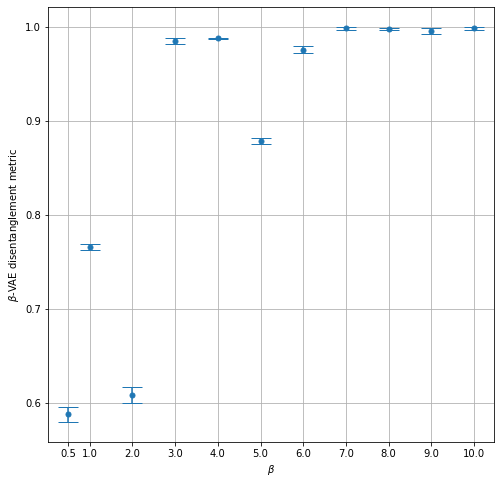

In [54]:
# plot 2-stddev to show 95% confidence
fig = plt.figure(num=1, figsize=(8, 8))
_, caps, _ = plt.errorbar(x=([0.5] + list(range(1, 11))),
                          y=np.mean(accs, axis=1), yerr=(np.std(accs, axis=1)*2),
                          fmt='o', markersize=5, capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xticks([0.5] + list(range(1, 11)))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\beta$-VAE disentanglement metric");
plt.grid()
plt.savefig("beta_search.png")